<a href="https://colab.research.google.com/github/dlskawns/coz-project/blob/main/CP2_%EA%B8%B0%ED%9A%8D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dask 활용
# pip install dask[complete]

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from pandas.io import gbq


In [ ]:
%%time
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/2019-Oct.csv')

In [ ]:
#압축에 3분 7초 걸림
df.to_parquet('parquetted_df', compression = 'gzip')

In [6]:
%%time
import pandas as pd
df = pd.read_parquet('/content/parquetted_df')


CPU times: user 32.8 s, sys: 7.19 s, total: 40 s
Wall time: 29 s


In [ ]:
import numpy as np
@np.vectorize
def ordinal_labeling()

In [12]:
len(df.product_id.unique())

166794

In [7]:
%%time 
df.event_type = df.event_type.map(lambda x: 0 if x == 'view' else ( 1 if x == 'cart' else 2))

CPU times: user 14 s, sys: 959 ms, total: 14.9 s
Wall time: 14.8 s


## EDA

In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     int64  
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 2.8+ GB


In [12]:
df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [57]:
df['brand'].value_counts()[:5]

samsung    5282775
apple      4122554
xiaomi     3083763
huawei     1111205
lucente     655861
Name: brand, dtype: int64

In [60]:
# 카테고리 NULL값이면서 브랜드는 기재되어있는 샘플 확인
df[(df['category_code'].isnull())&(df['brand'].notnull())]['brand'].value_counts()[:10]

lucente     655861
xiaomi      386119
cordiant    368277
sony        235406
stels       231895
bosch       227255
triangle    212952
nokian      185123
force       166369
redmond     153856
Name: brand, dtype: int64

In [73]:
# Top5 brand 별 가장 많은 카테고리 파악

df[df['brand']=='lucente']['category_code']

53          None
58          None
85          None
150         None
264         None
            ... 
42447923    None
42448006    None
42448291    None
42448464    None
42448617    None
Name: category_code, Length: 655861, dtype: object

In [77]:
df[df['brand']=='xiaomi']['category_code'].value_counts()[:5]

electronics.smartphone           2200549
electronics.audio.headphone       214202
electronics.clocks                 91311
appliances.environment.vacuum      60227
kids.skates                        27165
Name: category_code, dtype: int64

In [78]:
df[df['category_code'].notnull()].corrwith(df[df['category_code'].notnull()]['price'])

event_type     0.013485
product_id    -0.264128
category_id   -0.070843
price          1.000000
user_id       -0.009659
dtype: float64

In [84]:
df[(df['brand']=='xiaomi')&(df['category_code']=='electronics.smartphone')]['price']


23          197.55
122         456.45
143         456.45
233         450.46
287         452.81
             ...  
42448687    212.10
42448705    437.33
42448732    136.37
42448751     94.46
42448752    437.33
Name: price, Length: 2200549, dtype: float64

In [87]:
df[df['brand']=='xiaomi'].groupby('category_code')['price'].mean()

category_code
accessories.bag                        29.861061
accessories.umbrella                   25.480000
appliances.environment.air_heater     127.058784
appliances.environment.vacuum         349.647526
appliances.kitchen.blender             50.172904
appliances.kitchen.coffee_machine     115.830000
appliances.kitchen.kettle              38.474236
appliances.personal.massager           90.990000
appliances.personal.scales             34.942993
auto.accessories.compressor            79.800000
auto.accessories.videoregister         63.105281
computers.desktop                      87.520000
computers.notebook                   1082.306910
computers.peripherals.mouse            18.376994
construction.tools.generator           21.620000
construction.tools.light               70.530645
electronics.audio.headphone            31.455566
electronics.camera.video              140.604210
electronics.clocks                    108.340844
electronics.smartphone                231.794455
electr

In [91]:
from scipy.stats import chi2_contingency
# df_n = df[df['category_code'].notnull()]
# df_cross = pd.crosstab(df_n['category_code'], df_n['category_id'])

chi2 = chi2_contingency(df_cross, correction = False)
# 엉망의 결과지만 우선 관련이 있다고 생각하고 진행해본다.

In [8]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [ ]:
!pip install category_encoders

In [ ]:
#brand, price, category_id를 바탕으로 머신러닝 모델에 target(category_code)을 예측하도록 만든다. 
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import copy
# from sklearn.preprocessing import 

sdf = df.copy()

ord = OrdinalEncoder()
sdf = ord.fit_transform(sdf)


sdf_train, sdf_test = train_test_split(sdf, test_size= 0.2, random_state = 2)
sdf_val, sdf_test= train_test_split(sdf_test, test_size = 0.2, random_state = 2)

target = 'category_code'
features = ['category_id', 'brand','price']



x_train = sdf_train[features]
y_train = sdf_train[target]
x_val = sdf_val[features]
y_val = sdf_val[target]
x_test = sdf_test[features]
y_test = sdf_test[target]

In [103]:
df['category_code'].value_counts()

electronics.smartphone          11507231
electronics.clocks               1311033
computers.notebook               1137623
electronics.video.tv             1113750
electronics.audio.headphone      1100188
                                  ...   
construction.tools.soldering         632
apparel.shorts                       632
apparel.jacket                       436
auto.accessories.anti_freeze         308
country_yard.furniture.bench         190
Name: category_code, Length: 126, dtype: int64

In [99]:
%%time
logit = LogisticRegression()
logit.fit(x_train, y_train)
# y_pred = logit.predict(x_val, y_val)

ValueError: ignored

In [80]:
import numpy as np
cat_list = df[df['brand']=='xiaomi']['category_code'].value_counts()[:5]

for i in cat_list:
  print(np.mean(df[(df['brand']=='xiaomi')&(df['category_code']==i)]['price']))

nan
nan
nan
nan
nan


In [69]:
print(f"브랜드와 카테고리 모두 결측인 경우: {len(df[(df['category_code'].isnull())&(df['brand'].isnull())])}")
print(f"브랜드는 있고 카테고리만 결측인 경우: {len(df[(df['category_code'].isnull())&(df['brand'].notnull())])}")
print(f"브랜드는 결측이면서 카테고리만 있는경우: {len(df[(df['category_code'].notnull())&(df['brand'].isnull())])}")
print(f"카테고리 결측이면서 구매된 경우: {len(df[(df['category_code'].isnull())&(df['event_type'] == 'purchase')])}")

브랜드와 카테고리 모두 결측인 경우: 3744547
브랜드는 있고 카테고리만 결측인 경우: 9771062
브랜드는 결측이면서 카테고리만 있는경우: 2372533
카테고리 결측이면서 구매된 경우: 0


In [70]:
print(f"카테고리 결측이면서 구매된 경우: {len(df[(df['category_code'].isnull())&(df['event_type'] == 'purchase')])}")
print(f"카테고리 결측이면서 장바구니 추가된 경우: {len(df[(df['category_code'].isnull())&(df['event_type'] == 'cart')])}")

카테고리 결측이면서 구매된 경우: 0
카테고리 결측이면서 장바구니 추가된 경우: 0


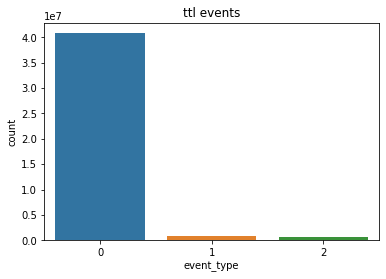

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df.event_type, order = df.event_type.value_counts().index)
plt.title('ttl events')
plt.show();

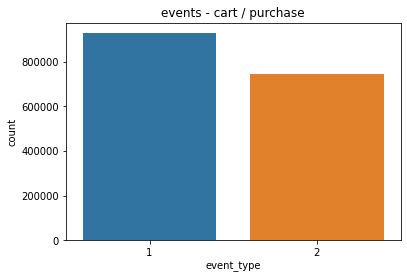

CPU times: user 765 ms, sys: 5.99 ms, total: 771 ms
Wall time: 702 ms


In [9]:
%%time
sns.countplot(df[df['event_type']!= 0]['event_type'])
plt.title('events - cart / purchase')
plt.show();

In [15]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 3.5 MB/s 


In [16]:
from category_encoders import OrdinalEncoder

In [ ]:
# df.to_gbq(destination_table='dataset_second.oct',
# 		  project_id='secondproject-351111',
# 		  if_exists='replace')

In [21]:
%%time
import pandas as pd

sql = "SELECT * FROM dataset_second.oct WHERE event_type = 'purchase'"
project_id = 'secondproject-351111'

df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

CPU times: user 24.4 s, sys: 592 ms, total: 25 s
Wall time: 2min 51s


In [22]:
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-11 11:05:51+00:00,purchase,9700060,2053013554096767303,computers.components.power_supply,cougar,61.52,543905943,b885532e-04c5-4215-beaf-55ac9e42d927
1,2019-10-11 13:32:11+00:00,purchase,6800050,2053013554222596431,computers.components.hdd,toshiba,45.16,523369625,7fc07c56-b4c6-4316-a6ea-30723b78b8f4
2,2019-10-04 07:32:11+00:00,purchase,9400066,2053013566067311601,None,jaguar,164.10,546418368,735c3918-10c4-467e-b1b9-7e643d7018ae
3,2019-10-08 15:12:41+00:00,purchase,42000011,2102307650380235197,None,pt-group,180.18,540344018,e7bf4163-b0e9-4675-9f98-61e7894ecd18
4,2019-10-12 18:05:38+00:00,purchase,12400121,2053013556252639687,construction.tools.drill,alteco,45.82,512536746,aff9fc6d-6d62-41bb-bf78-94471561922f
...,...,...,...,...,...,...,...,...,...
742844,2019-10-02 04:49:51+00:00,purchase,12711175,2053013553559896355,None,triangle,38.61,521461857,6e6be423-ad16-4d41-8fcc-6749a4ffb642
742845,2019-10-12 12:30:37+00:00,purchase,12701305,2053013553559896355,None,triangle,42.99,516768299,c0264be2-974a-41a7-9481-637610b10160
742846,2019-10-20 10:44:24+00:00,purchase,12716409,2053013553559896355,None,triangle,34.75,534825158,51b96af3-8f55-426b-80f5-1e609e41cea9
742847,2019-10-08 12:12:47+00:00,purchase,12701289,2053013553559896355,None,triangle,42.21,515311602,d57e8c0d-0b57-4be7-886c-06ede16cf6b0


In [ ]:
# from dask.distributed import LocalCluster, Client

# cluster = LocalCluster()
# client = Client(cluster)


In [ ]:
# from bokeh.plotting import figure, show, output_notebook
# from bokeh.transform import factor_cmap, factor_mark

In [ ]:
# %%time
# import dask.dataframe as dd


# df1 = dd.read_csv('/content/drive/MyDrive/2019-Oct.csv')

CPU times: user 477 ms, sys: 49.6 ms, total: 527 ms
Wall time: 526 ms


In [ ]:
# df['event_time'] = df['event_time'].map(lambda x: x[11:-4])
df1['event_time']

In [ ]:
df1_utc = df1[['event_time','event_type','category_code']]
df1_utc['event_time'] = df1_utc['event_time'].map(lambda x: x[11:-4])
# df1_utc

In [ ]:
df1_utc['event_time'][:10]

NotImplementedError: ignored

In [ ]:
df1_utc['event_time'] = df1_utc['event_time'].value_counts().compute()


In [ ]:
df['event_time'] = df['event_time'].map(lambda x: x[11:13])

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [ ]:
df['event_time'].value_counts()


16    3054743
15    2980890
17    2733718
14    2678550
8     2390127
13    2354992
9     2351683
7     2335718
10    2297177
6     2269092
11    2193895
12    2137868
5     2125633
18    2124963
4     1915643
3     1550285
19    1341170
2     1069047
20     744224
1      559027
21     438422
0      306805
22     273055
23     222037
Name: event_time, dtype: int64

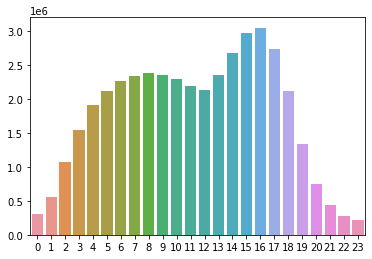

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# df_utc = df[['event_time','event_type','category_code']]
# df['event_time'] = df['event_time'].astype('int')
sns.barplot(df['event_time'].value_counts().index, df['event_time'].value_counts().values)

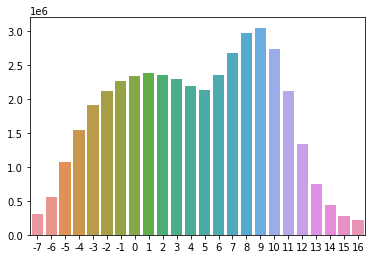

In [ ]:
sns.barplot((df['event_time']-7).value_counts().index, (df['event_time']-7).value_counts().values)

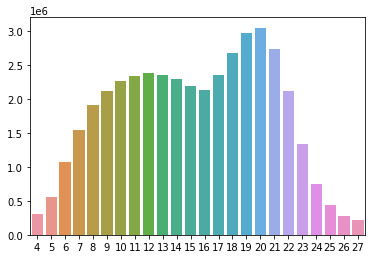

In [ ]:
sns.barplot((df['event_time']+4).value_counts().index, (df['event_time']+4).value_counts().values)

In [ ]:
df_utc

In [ ]:
type(df1_utc)

dask.dataframe.core.DataFrame

In [ ]:
df1.count().compute()

event_time       42448764
event_type       42448764
product_id       42448764
category_id      42448764
category_code    28933155
brand            36331684
price            42448764
user_id          42448764
user_session     42448762
dtype: int64

In [ ]:
df1.event_time.describe().compute()

unique                    2621538
count                    42448764
top       2019-10-15 08:52:00 UTC
freq                          116
Name: event_time, dtype: object

In [ ]:
plt.plot(df1['event_time'].value_counts())

In [ ]:

df1_utc['event_time'].map(lambda x: x[12:-4])


Dask Series Structure:
npartitions=89
    object
       ...
     ...  
       ...
       ...
Name: event_time, dtype: object
Dask Name: map, 534 tasks

In [ ]:
df_utc = df_utc['event_time']

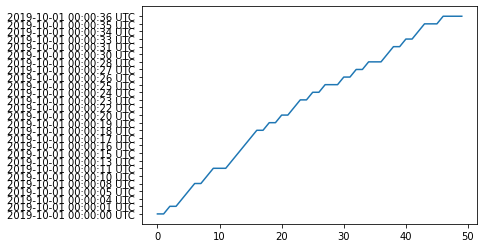

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['event_time'], df['event_type'])

In [ ]:
df.event_type.unique()

array(['view', 'purchase', 'cart'], dtype=object)

In [ ]:
len(df.user_session.unique())

9244422

In [ ]:
df['date'] = pd.to_datetime(df['event_time'])

In [ ]:
df['date'][0]

Timestamp('2019-10-01 00:00:00+0000', tz='UTC')

In [ ]:
df['date'] = df['event_time'].map(lambda x: x[:10])

In [ ]:
# 일자 확인 -> 10-01 ~ 10-31 데이터
df['date'].unique()

array(['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-04',
       '2019-10-05', '2019-10-06', '2019-10-07', '2019-10-08',
       '2019-10-09', '2019-10-10', '2019-10-11', '2019-10-12',
       '2019-10-13', '2019-10-14', '2019-10-15', '2019-10-16',
       '2019-10-17', '2019-10-18', '2019-10-19', '2019-10-20',
       '2019-10-21', '2019-10-22', '2019-10-23', '2019-10-24',
       '2019-10-25', '2019-10-26', '2019-10-27', '2019-10-28',
       '2019-10-29', '2019-10-30', '2019-10-31'], dtype=object)

In [ ]:
# 유저 수
len(df['user_id'].unique())

3022290

In [ ]:
# 상품 수
len(df['product_id'].unique())

166794

In [ ]:
# 카테고리 수
len(df['category_code'].unique())

127

In [ ]:
# 브랜드 수
len(df['brand'].unique())

3445

In [ ]:
df[df['user']=='purchase']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


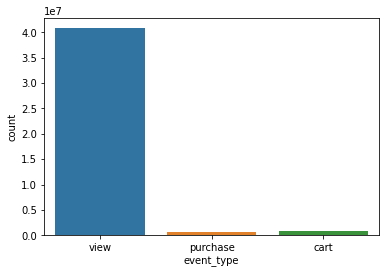

In [ ]:
import seaborn as sns

sns.countplot(df['event_type'])

In [ ]:
# purchase한 유저의 수
p_user = df[df['event_type']=='purchase']['user_id'].values
p_product = df[df['event_type']=='purchase']['product_id'].unique()

In [ ]:
purchased_df = df[(df['product_id'].isin(p_product))&(df['user_id'].isin(p_user))]

In [ ]:
purchased_df.groupby(['product_id','user_id'])['event_type'].count()

product_id  user_id  
1000978     512366656    1
            512399128    1
            512448158    1
            512457400    4
            512458113    3
                        ..
60500002    563964152    1
            564022246    1
            564294383    1
60500009    514446250    4
            529839452    1
Name: event_type, Length: 5125172, dtype: int64

In [ ]:
df[(df['product_id']==1000978)&(df['user_id']==543856131)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
29058703,2019-10-21 18:11:12 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,b040fde0-f103-4016-8cfd-9b1433b287ff
29060613,2019-10-21 18:12:34 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,b040fde0-f103-4016-8cfd-9b1433b287ff
29061934,2019-10-21 18:13:29 UTC,purchase,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,b040fde0-f103-4016-8cfd-9b1433b287ff
29062548,2019-10-21 18:13:54 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,b040fde0-f103-4016-8cfd-9b1433b287ff
33629489,2019-10-25 06:37:50 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,633ce9d4-a793-4cd9-ad10-ceb7de93f984
33630868,2019-10-25 06:38:52 UTC,purchase,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,633ce9d4-a793-4cd9-ad10-ceb7de93f984
33631894,2019-10-25 06:39:37 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,633ce9d4-a793-4cd9-ad10-ceb7de93f984


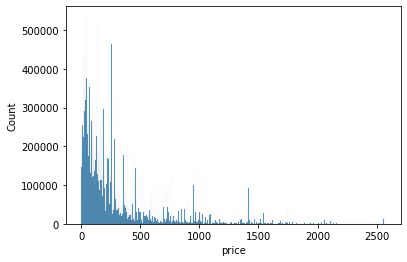

In [ ]:
sns.histplot(df['price'])
plt.show();

In [ ]:
# df['temp_vlookup'] = df['product_id'].astype(str) + df['user_id'].astype(str)


In [ ]:
re_order_count = df[df['event_type']=='purchase'].groupby(['product_id','user_id'])['event_type'].count()

In [ ]:

df = pd.merge(left=df, right=pd.DataFrame(re_order_count).reset_index(), how='left', \
                  on=['product_id','user_id'])

# df.join(pd.DataFrame(re_order_count), on = 'event_type')
# df.join(re_order_count, on = 'event_type')

In [ ]:
df.rename(columns = {'event_type_x': 'event_type', 'event_type_y':'reorder_cnt'}, inplace = True)

In [ ]:
df['reorder_cnt']

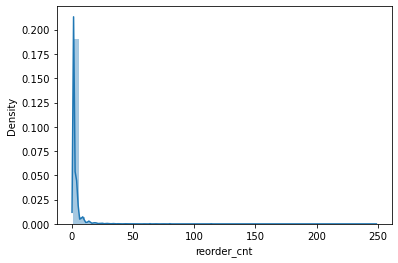

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 특정 상품에 대한 같은 월 내 구매 세션 수
sns.distplot(df['reorder_cnt'])
plt.show();

In [ ]:
# 구매를 한 적이 없는 사람 = reorder_cnt -> null인 고객 3천8백만
len(df[df['reorder_cnt'].isnull()])

38028564

In [ ]:
df[df['event_type']=='purchase']

In [ ]:
df.join(re_order_count.reset_index(), )

In [ ]:
len(df['user_session'].unique())

9244422

In [ ]:
for i in df['user_session'].unique():
  if len(df[df['user_session']==i]['product_id'].unique()) >1:
    print(df[df['user_session']==i]['product_id'].unique())

[17200506 15100337 15100008 15100367 15100034 15100220 15100214 15100288
 15100100]
[1307067 1306631 1306083 1307370 1306359]
[1004237 1005135]
[1480613 1480714 1480734 1480456 6700940]
[31500053 31501072 31501163]
[28719074 28719071]
[1004545 1801555 1801796]
[3900746 3900930]
[13500240 13500046 13500041 17200142 16800186 16800331 21405154 21403078]
[23100006 50500080]
[10900029  1004874  1004870]
[34700031 34700023]
[27500014 27500015  3701226]
[19001139 19000296 19000997 19000265 19002624 19002623 19001214]
[10800001 10800076 10800132 10800025 10800048  3300314]
[26200591 26201858]
[28714755 28708392 28715758 28715611 28717034 28704388]
[3701388 3701062 3700823 4600542]
[26200591 26201000 26201858 26400672]
[4300070 4300376 4300285]
[1004767 1004659]
[26500313 26500144 21403078 21402696]
[4100126 4100274 4100219 4100348]
[ 1005105 12709227  1005115]
[1307135 1307004]
[1005073 1004158]
[1004870 1004433 1004659 1004767]
[27700113 27701120 27700106]
[ 1004836 18000928  1005100]
[326010

In [ ]:
re_order_count = df[df['event_type']=='purchase'].groupby(['product_id','user_id'])['event_type'].count()
for i in range(len(re_order_count)):
  
# for i,j zip(re_order_count.index[0], re_order_count[1]):


MultiIndex([( 1000978, 517432921),
            ( 1000978, 518478766),
            ( 1000978, 532945616),
            ( 1000978, 543856131),
            ( 1000978, 547479795),
            ( 1000978, 559680841),
            ( 1000978, 560163787),
            ( 1000978, 561564140),
            ( 1000978, 564224920),
            ( 1000978, 565469756),
            ...
            (60400006, 512981817),
            (60500001, 531271515),
            (60500001, 553184946),
            (60500001, 555658150),
            (60500001, 558801181),
            (60500002, 513065871),
            (60500002, 517647881),
            (60500002, 526608637),
            (60500002, 556102277),
            (60500009, 514446250)],
           names=['product_id', 'user_id'], length=558484)

In [ ]:
for i in df[df['event_type']=='purchase']:
  df[df['product_id']==i['product_id']

['brand',
 'category_code',
 'category_id',
 'event_time',
 'event_type',
 'price',
 'product_id',
 'user_id',
 'user_session']

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import dates


# datetime.strptime(df['date'][0], '%Y-%m-%d %H:%M:%S')

plt.figure()
plt.plot(df.groupby('date').sum()['price'], 'b.-')
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.MinuteLocator())

In [ ]:
import pandas as pd
import json

json_file_path = '/content/drive/MyDrive/스마트폰_로그_데이터셋.json'

with open(json_file_path, 'r') as j:
  json.loads(j.read())


JSONDecodeError: ignored

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/smartphon_1.csv')


,id,timestamp,utcoffset,subject_id,source_type,source_info,package_name,name,is_system_app,is_updated_system_app,type
0,4,1540790989686,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,USER_INTERACTION
1,7,1540790994228,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
2,10,1540790994420,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND
3,13,1540790994486,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
4,16,1540791001635,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND


In [ ]:
for i in range(33):
  print(len(df[df['subject_id']==df['subject_id'].unique()[i]]))

23242
47764
76989
57349
67326
29861
50692
24394
51539
129091
51969
39344
51421
33892
20516
682
26971
41334
72934
30124
16615
57593
24304
130600
25739
34508
76860
43688
63364
57133
27382
76904
26214


In [ ]:
df['type'].unique()

array(['USER_INTERACTION', 'MOVE_TO_FOREGROUND', 'MOVE_TO_BACKGROUND',
       'CONFIGURATION_CHANGE', 'NONE', 'SHORTCUT_INVOCATION'],
      dtype=object)

In [ ]:
df['name'].unique()

array(['BAND', '연락처', 'TouchWiz 홈', '삼성 인터넷', 'Google', '전화', 'Fitbit',
       'ABC Platform', '메시지', '알람/시간', '실행 중인 애플리케이션', 'Samsung Health',
       '네이버 카페', '카카오톡', 'Burgerking', '모아락', '캐시워크',
       'Samsung Experience 홈', '카메라', '안드로이드 시스템', 'L.POINT', '시스템 UI',
       '하이웍스', '하이웍스 메신저', 'Samsung Pay', '내 파일', 'Polaris Office', 'NFC',
       'LINE', '다운로드 관리자', 'PowerPoint', '설정', 'NAVER', 'CJ ONE', '코레일톡',
       'Gear S Plugin', 'SR 고속열차', 'Melon', 'T map', '카카오뱅크', 'Instagram',
       'KB스타뱅킹', 'KB스마트원 통합인증', 'Gmail', '마이\n홈플러스', '원터치알림', 'CLiP',
       '원터치개인', '시계', '위비멤버스', 'AhnLab V3 Mobile Plus 2.0', 'KB스타알림',
       '네이버TV', '날씨', 'Google Play 뮤직', 'Samsung Themes', '갤러리', '삼성 캡처',
       '네이버 사전', 'Google Play 스토어', '머큐리코리아', 'NS홈쇼핑', 'Chrome',
       'kt M모바일', 'KBO', '우리카드', '헤이카카오', '호텔스컴바인', '소프트웨어 업데이트',
       'SBS고릴라', 'AhnLab V3 Mobile Security', 'Coinstep',
       'CaptivePortalLogin', 'CGV', '업비트', '파인더', '음성 녹음', '후후', '네이버 지도',
       '똑똑가계부', '카카오스토리', '

In [ ]:
df[df['subject_id']==df['subject_id'].unique()[1]]

,id,timestamp,utcoffset,subject_id,source_type,source_info,package_name,name,is_system_app,is_updated_system_app,type
180,544,1540765803075,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.clockpackage,알람/시간,1,0,MOVE_TO_FOREGROUND
181,547,1540765803086,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.clockpackage,알람/시간,1,0,MOVE_TO_BACKGROUND
182,550,1540765805069,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.clockpackage,알람/시간,1,0,MOVE_TO_FOREGROUND
183,553,1540765810494,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.clockpackage,알람/시간,1,0,MOVE_TO_BACKGROUND
184,556,1540765810584,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.taskmanager,실행 중인 애플리케이션,1,0,MOVE_TO_FOREGROUND
...,...,...,...,...,...,...,...,...,...,...,...
1086414,1105887,1540758799216,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,kvp.jjy.MispAndroid320,ISP/페이북,0,0,MOVE_TO_FOREGROUND
1086415,1105888,1540758799226,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,kvp.jjy.MispAndroid320,ISP/페이북,0,0,MOVE_TO_BACKGROUND
1086416,1105889,1540758799708,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.taskmanager,실행 중인 애플리케이션,1,0,MOVE_TO_BACKGROUND
1086417,1105890,1540758799709,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.taskmanager,실행 중인 애플리케이션,1,0,MOVE_TO_FOREGROUND


In [ ]:
df[df['subject_id']==df['subject_id'][0]]

,id,timestamp,utcoffset,subject_id,source_type,source_info,package_name,name,is_system_app,is_updated_system_app,type
0,4,1540790989686,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,USER_INTERACTION
1,7,1540790994228,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
2,10,1540790994420,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND
3,13,1540790994486,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
4,16,1540791001635,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND
...,...,...,...,...,...,...,...,...,...,...,...
826192,845665,1540789817283,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
826193,845666,1540789818740,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND
826194,845667,1540789818804,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.samsung.android.contacts,연락처,1,0,MOVE_TO_FOREGROUND
826195,845668,1540789820013,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.fitbit.FitbitMobile,Fitbit,0,0,USER_INTERACTION


In [ ]:
with open('/content/drive/MyDrive/스마트폰_로그_데이터셋2.json', 'r') as json_file:
    json_data = json_file.read()
    # json_data = json.load(json_file)
    # utf_data = json_data.decode('utf-8')
    # ascii_data = json_data.encode('ascii', 'ignore')

In [ ]:
print(json_data[:100])

[
  {
    "timestamp": 1540790989686,
    "utcoffset": 9,
    "pid": "2099efc17d719274924b8c81543c79


In [ ]:
print(json_data[-100:])

 "package_name": "com.kakao.talk",
    "name": "카카오톡",
    "is_system_app": 0,
    "is_updated_syste


In [ ]:
a = '{"is_updated_syste"}'

print(a)

{"is_updated_syste"}


In [ ]:
json_data = json_data+

In [ ]:
# import io

# downloaded = io.BytesIO()
for i in range(1000):
  print(json_data[i])

In [ ]:
from pandas import json_normalize
df = json_normalize(json_data['timestamp']) #Results contain the required data
print(df)

TypeError: ignored

In [ ]:
type(json_data)

str